<a href="https://colab.research.google.com/github/psingh-xyz/Practical_DL/blob/spring23/week03_covnets/psingh_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="https://github.com/yandexdataschool/Practical_DL/blob/spring23/week03_convnets/cifar10.jpg?raw=1" style="width:80%">

In [ ]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2023-12-27 08:28:12--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2023-12-27 08:28:12 (45.7 MB/s) - ‘cifar.py’ saved [2396/2396]



In [ ]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


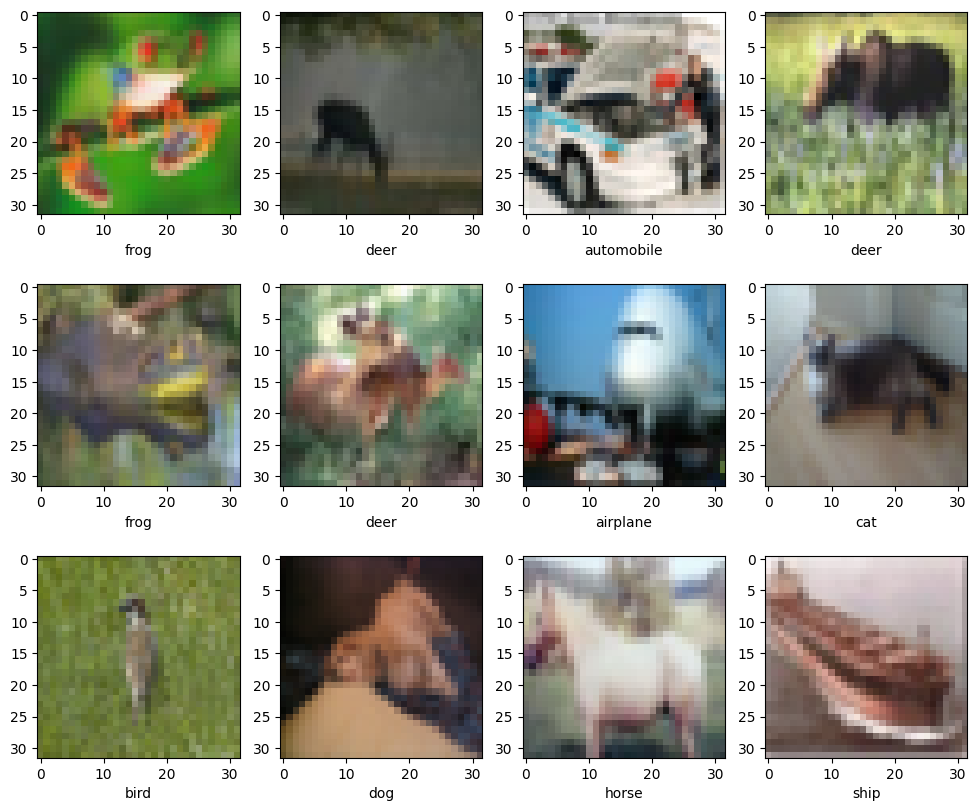

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [ ]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.2669, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [ ]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [ ]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 1.742s
  training loss (in-iteration): 	2.027348
  validation accuracy: 			34.36 %
Epoch 2 of 100 took 1.578s
  training loss (in-iteration): 	1.854571
  validation accuracy: 			36.17 %
Epoch 3 of 100 took 1.570s
  training loss (in-iteration): 	1.787503
  validation accuracy: 			38.11 %
Epoch 4 of 100 took 1.543s
  training loss (in-iteration): 	1.739930
  validation accuracy: 			39.96 %
Epoch 5 of 100 took 2.005s
  training loss (in-iteration): 	1.702066
  validation accuracy: 			40.35 %
Epoch 6 of 100 took 1.947s
  training loss (in-iteration): 	1.667136
  validation accuracy: 			42.29 %
Epoch 7 of 100 took 1.540s
  training loss (in-iteration): 	1.640109
  validation accuracy: 			42.59 %
Epoch 8 of 100 took 1.499s
  training loss (in-iteration): 	1.614295
  validation accuracy: 			43.99 %
Epoch 9 of 100 took 1.498s
  training loss (in-iteration): 	1.592576
  validation accuracy: 			44.31 %
Epoch 10 of 100 took 1.520s
  training loss (in-iteration): 	1.575745
  v

KeyboardInterrupt: ignored

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		49.45 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [ ]:
import torch.nn as nn

# Define the mini-convolutional network
class MiniConvNet(nn.Module):
    def __init__(self):
        super(MiniConvNet, self).__init__()
        # Input layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.flatten = Flatten()  # Assuming Flatten is defined elsewhere
        self.dense1 = nn.Linear(10 * 15 * 15, 100)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.1)  # 10% dropout
        self.dense2_logits = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.dense2_logits(x)
        return x

# Create the main model and add the mini-convolutional network
model = nn.Sequential(MiniConvNet())



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time


# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

# Training settings
num_epochs = 100
batch_size = 50

train_loss = []
val_accuracy = []

def convert_to_tensor(data, dtype):
    return torch.as_tensor(data, dtype=dtype)

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train(True)  # Enable dropout / batch_norm training behavior
    start_time = time.time()

    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        X_batch, y_batch = convert_to_tensor(X_batch, torch.float32), convert_to_tensor(y_batch, torch.int64)

        logits = model(X_batch)
        loss = F.cross_entropy(logits, y_batch)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())

    # Validation phase
    model.train(False)  # Disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        X_batch = convert_to_tensor(X_batch, torch.float32)
        logits = model(X_batch)
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    # Print results for this epoch
    print(f"Epoch {epoch + 1} of {num_epochs} took {time.time() - start_time:.3f}s")
    training_loss_mean = np.mean(train_loss[-len(X_train) // batch_size:])
    val_accuracy_mean = np.mean(val_accuracy[-len(X_val) // batch_size:]) * 100
    print(f"  Training loss (in-iteration): \t{training_loss_mean:.6f}")
    print(f"  Validation accuracy: \t\t\t{val_accuracy_mean:.2f} %")


Epoch 1 of 100 took 8.927s
  Training loss (in-iteration): 	1.677986
  Validation accuracy: 			50.24 %
Epoch 2 of 100 took 10.638s
  Training loss (in-iteration): 	1.393252
  Validation accuracy: 			53.91 %
Epoch 3 of 100 took 10.239s
  Training loss (in-iteration): 	1.298970
  Validation accuracy: 			55.17 %
Epoch 4 of 100 took 10.172s
  Training loss (in-iteration): 	1.230976
  Validation accuracy: 			56.72 %
Epoch 5 of 100 took 10.020s
  Training loss (in-iteration): 	1.181307
  Validation accuracy: 			58.30 %
Epoch 6 of 100 took 9.117s
  Training loss (in-iteration): 	1.137467
  Validation accuracy: 			58.73 %
Epoch 7 of 100 took 9.914s
  Training loss (in-iteration): 	1.098988
  Validation accuracy: 			59.17 %
Epoch 8 of 100 took 9.992s
  Training loss (in-iteration): 	1.061690
  Validation accuracy: 			59.20 %
Epoch 9 of 100 took 9.920s
  Training loss (in-iteration): 	1.028071
  Validation accuracy: 			59.97 %
Epoch 10 of 100 took 9.437s
  Training loss (in-iteration): 	0.997649

KeyboardInterrupt: ignored

In [ ]:
model.eval()  # Set the model to evaluation mode (disable dropout / use averages for batch_norm)
test_batch_accuracy = []

# Assuming iterate_minibatches requires the batchsize argument
batch_size = 500  # Set the desired batch size
for X_batch, y_batch in iterate_minibatches(X_test, y_test, batchsize=batch_size):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    logits = model(X_batch)
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_accuracy.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_accuracy)

print("Final results:")
print(f"  Test accuracy:\t\t{test_accuracy * 100:.2f} %")

# The rest of the code remains the same
if test_accuracy * 100 > 95:
    print("Double-check, then consider applying for NIPS'17. Seriously.")
elif test_accuracy * 100 > 90:
    print("You're freakin' amazing!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructions below")


Final results:
  Test accuracy:		57.56 %
Achievement unlocked: 60lvl Warlock!


```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [ ]:
import torch.nn as nn

# Define the mini-convolutional network
class MiniConvNet(nn.Module):
    def __init__(self):
        super(MiniConvNet, self).__init__()
        # Input layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.flatten = Flatten()  # Assuming Flatten is defined elsewhere
        self.dense1 = nn.Linear(10 * 15 * 15, 100)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.1)  # 10% dropout
        self.dense2_logits = nn.Linear(100, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.dense2_logits(x)
        return x

# Create the main model and add the mini-convolutional network
model = nn.Sequential(MiniConvNet())

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# Training settings
num_epochs = 100
batch_size = 50

train_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    # Training
    model.train()  # Enable dropout during training
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        optimizer.zero_grad()
        X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
        y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
        logits = model(X_batch)
        loss = F.cross_entropy(logits, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Validation
    model.eval()  # Disable dropout during validation
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
        logits = model(X_batch)
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    print(f"Epoch {epoch + 1} of {num_epochs} took {time.time() - start_time:.3f}s")
    training_loss_mean = np.mean(train_loss[-len(X_train) // batch_size:])
    val_accuracy_mean = np.mean(val_accuracy[-len(X_val) // batch_size:]) * 100
    print(f"  Training loss (in-iteration): \t{training_loss_mean:.6f}")
    print(f"  Validation accuracy: \t\t\t{val_accuracy_mean:.2f} %")


Epoch 1 of 100 took 582.045s
  Training loss (in-iteration): 	1.689867
  Validation accuracy: 			46.51 %
Epoch 2 of 100 took 591.326s
  Training loss (in-iteration): 	1.427898
  Validation accuracy: 			52.19 %
Epoch 3 of 100 took 602.264s
  Training loss (in-iteration): 	1.307360
  Validation accuracy: 			55.68 %
Epoch 4 of 100 took 612.800s
  Training loss (in-iteration): 	1.217473
  Validation accuracy: 			57.24 %
Epoch 5 of 100 took 623.049s
  Training loss (in-iteration): 	1.161136
  Validation accuracy: 			58.96 %
Epoch 6 of 100 took 632.775s
  Training loss (in-iteration): 	1.106970
  Validation accuracy: 			58.77 %
Epoch 7 of 100 took 642.364s
  Training loss (in-iteration): 	1.062701
  Validation accuracy: 			59.52 %
Epoch 8 of 100 took 652.203s
  Training loss (in-iteration): 	1.027999
  Validation accuracy: 			59.25 %
Epoch 9 of 100 took 661.959s
  Training loss (in-iteration): 	0.997835
  Validation accuracy: 			59.17 %
Epoch 10 of 100 took 671.802s
  Training loss (in-itera

KeyboardInterrupt: ignored

In [ ]:
model.eval()  # Set the model to evaluation mode (disable dropout / use averages for batch_norm)
test_batch_accuracy = []

# Assuming iterate_minibatches requires the batchsize argument
batch_size = 500  # Set the desired batch size
for X_batch, y_batch in iterate_minibatches(X_test, y_test, batchsize=batch_size):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    logits = model(X_batch)
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_accuracy.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_accuracy)

print("Final results:")
print(f"  Test accuracy:\t\t{test_accuracy * 100:.2f} %")

# The rest of the code remains the same
if test_accuracy * 100 > 95:
    print("Double-check, then consider applying for NIPS'17. Seriously.")
elif test_accuracy * 100 > 90:
    print("You're freakin' amazing!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructions below")

Final results:
  Test accuracy:		58.66 %
Achievement unlocked: 60lvl Warlock!



```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [ ]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [ ]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader,
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


NotImplementedError: ignored

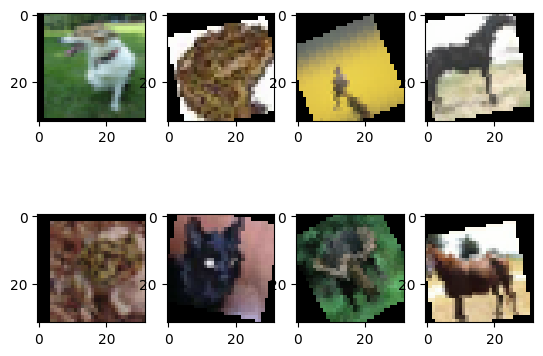

In [ ]:

for (x_batch, y_batch) in train_batch_gen:

    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)

    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )


    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

In [ ]:
from torchvision.datasets import CIFAR10

# Test data transformation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)
test_batch_gen = torch.utils.data.DataLoader(test_loader, batch_size=32, shuffle=False, num_workers=1)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MiniConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters())

X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


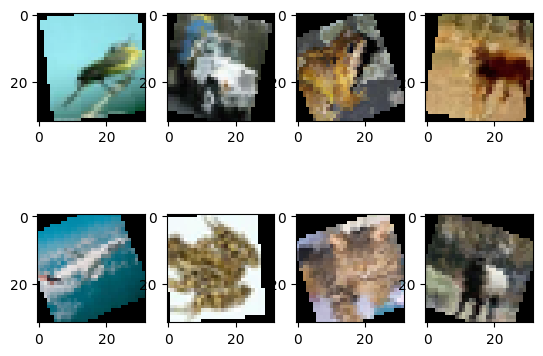

Epoch 1 of 100 took 1775.820s
  Training loss (in-iteration): 	1.385523
  Validation accuracy: 			55.16 %
Epoch 2 of 100 took 1812.012s
  Training loss (in-iteration): 	1.384907
  Validation accuracy: 			54.71 %
Epoch 3 of 100 took 1848.609s
  Training loss (in-iteration): 	1.383768
  Validation accuracy: 			54.82 %
Epoch 4 of 100 took 1883.231s
  Training loss (in-iteration): 	1.379104
  Validation accuracy: 			55.58 %
Epoch 5 of 100 took 1917.847s
  Training loss (in-iteration): 	1.377424
  Validation accuracy: 			54.54 %
Epoch 6 of 100 took 1952.168s
  Training loss (in-iteration): 	1.377615
  Validation accuracy: 			54.88 %
Epoch 7 of 100 took 1987.747s
  Training loss (in-iteration): 	1.377392
  Validation accuracy: 			54.26 %
Epoch 8 of 100 took 2024.519s
  Training loss (in-iteration): 	1.373088
  Validation accuracy: 			54.82 %
Epoch 9 of 100 took 2058.789s
  Training loss (in-iteration): 	1.369043
  Validation accuracy: 			56.47 %
Epoch 10 of 100 took 2093.779s
  Training loss

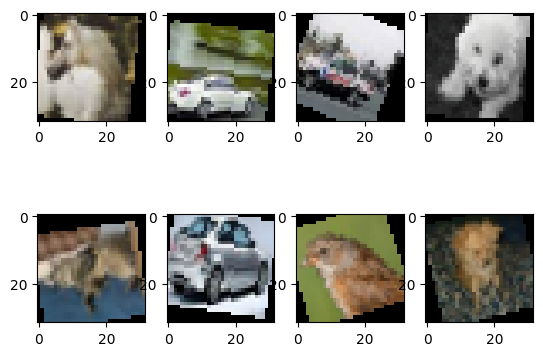

Epoch 11 of 100 took 2129.358s
  Training loss (in-iteration): 	1.368662
  Validation accuracy: 			55.85 %
Epoch 12 of 100 took 2163.884s
  Training loss (in-iteration): 	1.371188
  Validation accuracy: 			55.20 %
Epoch 13 of 100 took 2198.637s
  Training loss (in-iteration): 	1.369715
  Validation accuracy: 			54.70 %
Epoch 14 of 100 took 2232.943s
  Training loss (in-iteration): 	1.369697
  Validation accuracy: 			54.99 %
Epoch 15 of 100 took 2267.308s
  Training loss (in-iteration): 	1.365531
  Validation accuracy: 			55.69 %
Epoch 16 of 100 took 2301.833s
  Training loss (in-iteration): 	1.364639
  Validation accuracy: 			53.77 %
Epoch 17 of 100 took 2336.810s
  Training loss (in-iteration): 	1.364969
  Validation accuracy: 			56.46 %
Epoch 18 of 100 took 2371.224s
  Training loss (in-iteration): 	1.360115
  Validation accuracy: 			54.93 %
Epoch 19 of 100 took 2405.447s
  Training loss (in-iteration): 	1.362893
  Validation accuracy: 			56.49 %
Epoch 20 of 100 took 2440.458s
  Trai

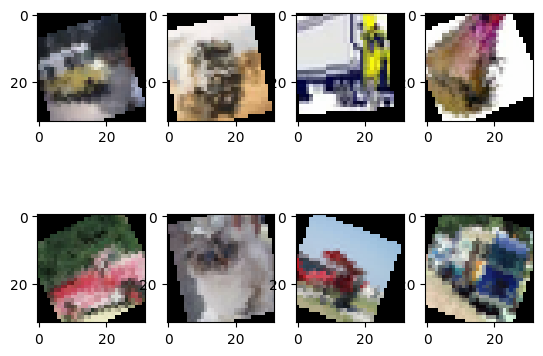

Epoch 21 of 100 took 2475.715s
  Training loss (in-iteration): 	1.362509
  Validation accuracy: 			56.23 %
Epoch 22 of 100 took 2511.116s
  Training loss (in-iteration): 	1.360315
  Validation accuracy: 			54.19 %
Epoch 23 of 100 took 2545.949s
  Training loss (in-iteration): 	1.360282
  Validation accuracy: 			55.10 %
Epoch 24 of 100 took 2580.649s
  Training loss (in-iteration): 	1.358576
  Validation accuracy: 			56.19 %
Epoch 25 of 100 took 2614.635s
  Training loss (in-iteration): 	1.358402
  Validation accuracy: 			56.11 %
Epoch 26 of 100 took 2649.187s
  Training loss (in-iteration): 	1.351647
  Validation accuracy: 			55.73 %
Epoch 27 of 100 took 2685.612s
  Training loss (in-iteration): 	1.359620
  Validation accuracy: 			55.92 %
Epoch 28 of 100 took 2719.551s
  Training loss (in-iteration): 	1.350572
  Validation accuracy: 			55.85 %
Epoch 29 of 100 took 2753.985s
  Training loss (in-iteration): 	1.352736
  Validation accuracy: 			57.30 %
Epoch 30 of 100 took 2788.290s
  Trai

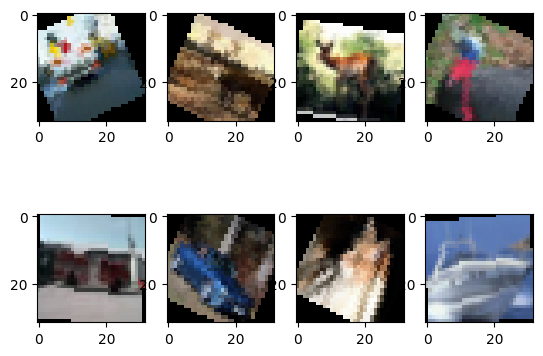

Epoch 31 of 100 took 2822.842s
  Training loss (in-iteration): 	1.351664
  Validation accuracy: 			56.12 %
Epoch 32 of 100 took 2857.773s
  Training loss (in-iteration): 	1.354624
  Validation accuracy: 			57.52 %
Epoch 33 of 100 took 2892.588s
  Training loss (in-iteration): 	1.352943
  Validation accuracy: 			57.65 %
Epoch 34 of 100 took 2927.731s
  Training loss (in-iteration): 	1.354557
  Validation accuracy: 			57.00 %
Epoch 35 of 100 took 2962.376s
  Training loss (in-iteration): 	1.350184
  Validation accuracy: 			56.60 %
Epoch 36 of 100 took 2998.294s
  Training loss (in-iteration): 	1.347167
  Validation accuracy: 			57.56 %
Epoch 37 of 100 took 3032.896s
  Training loss (in-iteration): 	1.348949
  Validation accuracy: 			56.25 %
Epoch 38 of 100 took 3067.052s
  Training loss (in-iteration): 	1.351971
  Validation accuracy: 			55.57 %


KeyboardInterrupt: ignored

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt

num_epochs = 100
batch_size = 32
train_loss = []
val_accuracy = []


for epoch in range(num_epochs):
    # Training
    model.train()  # Enable dropout and batch normalization during training

    for batch_idx, (X_batch, y_batch) in enumerate(train_batch_gen):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to GPU

        # Visualize the first batch of every epoch, just for checking augmentation
        if batch_idx == 0 and epoch % 10 == 0:  # every 10 epochs
            print('X:', type(X_batch), X_batch.shape)
            print('y:', type(y_batch), y_batch.shape)

            for i, img in enumerate(X_batch.cpu().numpy()[:8]):  # move tensor to cpu before converting to numpy
                plt.subplot(2, 4, i+1)
                plt.imshow(np.clip(img.transpose([1, 2, 0]) * stds + means, 0, 1))
            plt.show()

        optimizer.zero_grad()
        loss = compute_loss(X_batch, y_batch.to(device))
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Validation
    model.eval()
    for X_batch, y_batch in test_batch_gen:
        X_batch = X_batch.to(device)
        logits = model(X_batch)

        y_pred = logits.max(1)[1].detach().cpu().numpy()
        y_batch = y_batch.detach().cpu().numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    print(f"Epoch {epoch + 1} of {num_epochs} took {time.time() - start_time:.3f}s")
    training_loss_mean = np.mean(train_loss[-len(train_loader) // 32 :])
    val_accuracy_mean = np.mean(val_accuracy[-len(test_loader) // 32 :]) * 100
    print(f"  Training loss (in-iteration): \t{training_loss_mean:.6f}")
    print(f"  Validation accuracy: \t\t\t{val_accuracy_mean:.2f} %")


In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])


test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)
test_batch_gen = torch.utils.data.DataLoader(test_loader,
                                            batch_size=32,
                                            shuffle=False,
                                            num_workers=1)

In [ ]:
model.eval()  # Set the model to evaluation mode (disable dropout / use averages for batch_norm)
test_batch_accuracy = []

for X_batch, y_batch in test_batch_gen:
    X_batch = X_batch.to(device)
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    y_batch = y_batch.detach().cpu().numpy()
    test_batch_accuracy.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_accuracy)

print("Final results:")
print(f"  Test accuracy:\t\t{test_accuracy * 100:.2f} %")

if test_accuracy * 100 > 95:
    print("Double-check, then consider applying for NIPS'17. Seriously.")
elif test_accuracy * 100 > 90:
    print("You're freakin' amazing!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructions below")


Final results:
  Test accuracy:		54.67 %
Achievement unlocked: 60lvl Warlock!


# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.

## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons,
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   
### Data augmemntation
   * getting 5x as large dataset for free is a great
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


In [ ]:

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
model = MyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



NameError: ignored

In [ ]:

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')